In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from scipy.io import loadmat

In [2]:
path_data = "ex4data1.mat"
data = loadmat(path_data)
data['X'].shape, data['y'].shape

((5000, 400), (5000, 1))

In [3]:
X = data['X']
y = data['y']

In [4]:
path_weights = "ex4weights.mat"
weights = loadmat(path_weights)

theta1 = weights['Theta1']
theta2 = weights['Theta2']

theta1.shape, theta2.shape

((25, 401), (10, 26))

In [5]:
# 数字的绘制看ex3

In [6]:
# onhot-encoder
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
y_onehot = encoder.fit_transform(y)

y_onehot.shape, y_onehot[0, :]

((5000, 10), array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]))

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def feedforward(X, theta1, theta2):
    """前向传播"""
    a1 = np.insert(X, 0, np.ones(X.shape[0]), axis=1)  # 0表示插入的位置，又axis=1，在第0列插入1列1
    
    z2 = a1 @ theta1.T
    a2 = sigmoid(z2)
    a2 = np.insert(a2, 0, np.ones(a2.shape[0]), axis=1)
    
    z3 = a2 @ theta2.T
    a3 = sigmoid(z3)
    return a1, z2, a2, z3, a3

def cost_func(X, y, theta, input_size, hidden_size, num_labels, learning_rate):
    """代价函数"""
    theta1 = np.reshape(theta[:hidden_size * (input_size + 1)], (hidden_size, input_size + 1))
    theta2 = np.reshape(theta[hidden_size * (input_size + 1):], (num_labels, hidden_size + 1))
    
    a1, z2, a2, z3, a3 = feedforward(X, theta1, theta2)
   
    m = X.shape[0]
    J = 0
    for i in range(m):   # 对于所有的样本
        temp1 = -y[i,:] * np.log(a3[i,:])
        temp2 = (1-y[i,:]) * np.log(1 - a3[i,:])
        J += np.sum(temp1 - temp2)
    return J / m

In [8]:
input_size = 400
hidden_size = 25
num_labels = 10
learning_rate = 1

In [9]:
# 使用给定的theta1和theta2计算cost
params = np.concatenate([theta1.flatten(), theta2.flatten()])
cost_func(X, y_onehot, params, input_size, hidden_size, num_labels, learning_rate)

0.2876291651613187

In [10]:
def cost_func_reg(X, y, theta, input_size, hidden_size, num_labels, learning_rate):
    """正则化的代价函数"""
    theta1 = np.reshape(theta[:hidden_size * (input_size + 1)], (hidden_size, input_size + 1))
    theta2 = np.reshape(theta[hidden_size * (input_size + 1):], (num_labels, hidden_size + 1))
    
    a1, z2, a2, z3, a3 = feedforward(X, theta1, theta2)
   
    m = X.shape[0]
    J = 0
    for i in range(m):   # 对于所有的样本
        temp1 = -y[i,:] * np.log(a3[i,:])
        temp2 = (1-y[i,:]) * np.log(1 - a3[i,:])
        J += np.sum(temp1 - temp2)
    J = J / m
    
    # 添加正则化项，防止过拟合
    theta1 = theta1 ** 2
    theta2 = theta2 ** 2
    J += learning_rate * (np.sum(theta1[:, 1:]) + np.sum(theta2[:, 1:])) / (2 * m)
    return J

In [11]:
cost_func_reg(X, y_onehot, params, input_size, hidden_size, num_labels, learning_rate)

0.3837698590909234

In [12]:
# 反向传播算法

def sigmoid_grad(z):
    """sigmoid梯度"""
    return sigmoid(z) * (1 - sigmoid(z))

sigmoid_grad(100), sigmoid_grad(0)

(0.0, 0.25)

In [13]:
# 生成在[-0.12, 0.12]的随机数

# params = (np.random.random(hidden_size * (input_size + 1) + (hidden_size + 1)  * num_labels) - 0.5) * 0.24
params = (np.random.random(size=hidden_size * (input_size + 1) + num_labels * (hidden_size + 1)) - 0.5) * 0.24
params.shape

(10285,)

In [14]:
def back_prop(params, input_size, hidden_size, num_labels, X, y, learning_rate):
    theta1 = np.reshape(params[:hidden_size * (input_size + 1)], (hidden_size, input_size + 1))
    theta2 = np.reshape(params[hidden_size * (input_size + 1):], (num_labels, hidden_size + 1))
    
    a1, z2, a2, z3, a3 = feedforward(X, theta1, theta2)
   
    m = X.shape[0]
    J = 0
    for i in range(m):   # 对于所有的样本
        temp1 = -y[i,:] * np.log(a3[i,:])
        temp2 = (1-y[i,:]) * np.log(1 - a3[i,:])
        J += np.sum(temp1 - temp2)
    J /= m
    
    delta_theta1 = np.zeros(theta1.shape)
    delta_theta2 = np.zeros(theta2.shape)
    # 反向传播求dw
    for i in range(m):
        a1_t = a1[i, :].reshape(a1.shape[1], 1) # (401, 1)
        
        z2_t = z2[i, :].reshape(z2.shape[1], 1) # (25, 1)
        a2_t = a2[i, :].reshape(a2.shape[1], 1) # (26, 1)
        
        z3_t = z3[i, :].reshape(z3.shape[1], 1) # (10, 1)
        a3_t = a3[i, :].reshape(a3.shape[1], 1)
        y_t = y[i, :].reshape(y.shape[1], 1)
        
        delta3 = a3_t -  y_t # (10, 1)
        z2_t = np.insert(z2_t, 0, np.ones(1), axis=0)
        delta2 = theta2.T @ delta3 * sigmoid_grad(z2_t) # (26, 1)
       
        
        delta_theta1 += delta2[1:, :] @ a1_t.T # (25, 401)
        delta_theta2 += delta3 @ a2_t.T # (10, 26)
        
    delta_theta1 /= m
    delta_theta2 /= m
    grad = np.concatenate((np.ravel(delta_theta1), np.ravel(delta_theta2)))
    return J, grad


In [15]:
J, grad = back_prop(params, input_size, hidden_size, num_labels, X, y_onehot, learning_rate)
J, grad.shape

(7.082820877462879, (10285,))

In [16]:
from scipy.optimize import minimize

fmin = minimize(fun=back_prop, x0=params, args=(input_size, hidden_size, num_labels, X, y_onehot, learning_rate),
                method='TNC', jac=True, options={'maxiter': 250})
fmin

     fun: 0.02093586922252507
     jac: array([-3.65880296e-06,  0.00000000e+00,  0.00000000e+00, ...,
        5.76690432e-05,  3.61363337e-07,  5.10644241e-05])
 message: 'Max. number of function evaluations reached'
    nfev: 250
     nit: 23
  status: 3
 success: False
       x: array([-1.17453623, -0.02376137, -0.06276867, ...,  0.34829729,
       -1.26559405, -5.31643164])

In [17]:
X = np.matrix(X)
theta1 = np.reshape(fmin.x[:hidden_size * (input_size + 1)], (hidden_size, (input_size + 1)))
theta2 = np.reshape(fmin.x[hidden_size * (input_size + 1):], (num_labels, (hidden_size + 1)))

a1, z2, a2, z3, h = feedforward(X, theta1, theta2)
y_pred = np.array(np.argmax(h, axis=1) + 1)
y_pred

array([[10],
       [10],
       [10],
       ...,
       [ 9],
       [ 9],
       [ 9]])

In [18]:
# 计算预测准确率
correct = [1 if a == b else 0 for (a, b) in zip(y_pred, y)]
accuracy = (sum(map(int, correct)) / float(len(correct)))
print ('accuracy = {0}%'.format(accuracy * 100))

from sklearn.metrics import classification_report # 这个包是评价报告
print(classification_report(y, y_pred))

accuracy = 99.94%
              precision    recall  f1-score   support

           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500
           4       1.00      1.00      1.00       500
           5       1.00      1.00      1.00       500
           6       1.00      1.00      1.00       500
           7       1.00      1.00      1.00       500
           8       1.00      1.00      1.00       500
           9       1.00      1.00      1.00       500
          10       1.00      1.00      1.00       500

    accuracy                           1.00      5000
   macro avg       1.00      1.00      1.00      5000
weighted avg       1.00      1.00      1.00      5000



In [19]:
# 可视化隐藏层
hidden_layer = theta1[:, 1:]
hidden_layer.shape

(25, 400)

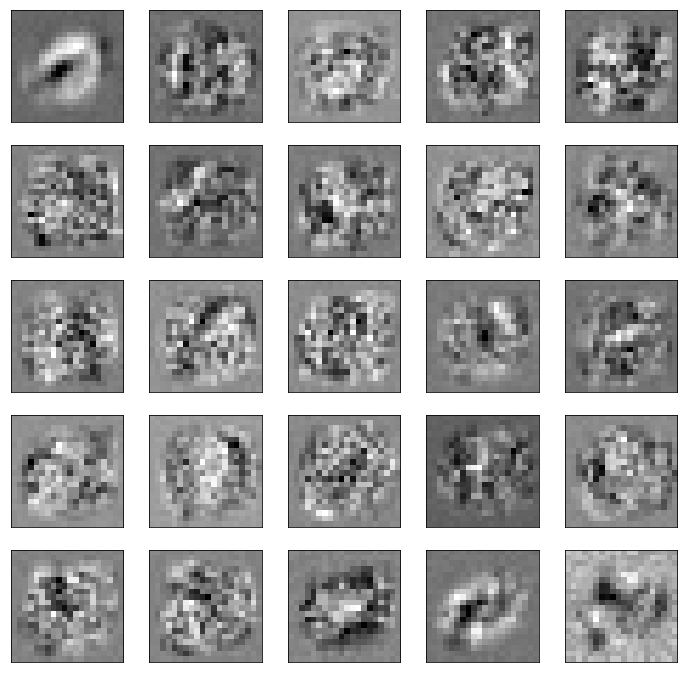

In [20]:
fig, ax_array = plt.subplots(nrows=5, ncols=5, sharey=True, sharex=True, figsize=(12, 12))
for r in range(5):
    for c in range(5):
        ax_array[r, c].matshow(np.array(hidden_layer[5 * r + c].reshape((20, 20))),cmap=matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([])) 